In [2]:
import pandas as pd
import numpy as np
import random
import os
import soundfile as sf
import librosa.util
import librosa.display
from pydub import AudioSegment, effects
from pydub.silence import split_on_silence
import zipfile
import shutil
from shutil import make_archive
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn

(44418960, 4)
(51680,)
(3438, 51680)
(3438, 100)
[[-4.15184735e+02 -1.12527513e+03 -4.09696522e+01  1.80499948e+03
  -2.50357590e+02 -2.62637271e+03 -1.11741350e+03  1.42833172e+03
  -1.96991087e+03  4.62679800e+02 -3.28332847e+03  4.14771605e+03
  -1.76909333e+03  1.21541326e+03 -6.29203350e+02 -1.79017584e+02
  -3.77455465e+02  2.09693379e+03 -4.72764342e+02  6.33691256e+02
  -1.67622582e+03  8.17842691e+01  1.48029345e+03 -1.37998143e+03
   2.96294571e+03 -5.49009358e+02 -9.70163495e+02  1.52145404e+03
  -8.50257856e+02  6.02133218e+01  9.51126762e+02  1.97369622e+01
  -2.05183555e+02  6.64025846e+01  8.97927462e+01 -2.18898666e+02
   3.75924760e+01  3.58476389e+01  4.56501927e+02  3.72189458e+01
  -2.65097061e+02  2.04302662e+02  1.53045382e+02 -1.49450900e+03
  -4.64659720e+02 -1.07908648e+03 -1.92147664e+02 -2.11180689e+02
   3.29536576e+02  1.22015539e+02  5.42263161e+02  2.17485838e+02
  -8.10278742e+02  7.58093244e+02  5.91954180e+01  1.22236815e+02
   4.71583977e+02  2.810641

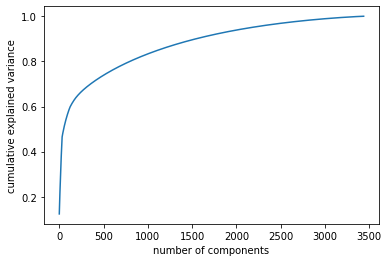

In [12]:
#читаем csv и определяем число наиболее значимых из 4*12920 мел-кепстральных коэффициентов
from sklearn.decomposition import PCA

def plot_pca_dispersion(song):
    pca = PCA().fit(song)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    return

def pca(song, n):
    pca = PCA(n_components=n)
    projected = pca.fit_transform(song)
    print(song.shape)
    print(projected.shape)
    return projected

if __name__ == '__main__':
    x_lim = 12920
    y_lim = 4
    
    song = pd.read_csv('genres_pca_mfcc.csv') #genres_pca_mfcc_small.csv
    lab = song['class']
    song = np.array(song[[str(i) for i in range(y_lim)]])
    print(song.shape)

    #разбиение на строки длиной 4*12920
    sound = np.zeros(shape = (1, x_lim * y_lim))
    label = []
    for i in range(song.shape[0] // x_lim):
        temp = song[i * x_lim : (i + 1) * x_lim, :]
        temp = temp.ravel()
        sound = np.vstack((sound, temp))
        label.append(lab[i * x_lim])
    sound = sound[1:, :]
    print(temp.shape)
                           
    plot_pca_dispersion(sound) #оставим 4 главных компоненты
    

    n_components = 100
    pca_song = pca(sound, n_components)
    print(pca_song[:5, :])
    
    result = pd.DataFrame(pca_song)
    result['class'] = pd.Series(label)
    result.to_csv('genres_pca_100_comp_of_song.csv', index = None)   #genres_pca_100_comp_of_song_small.csv
                

Отсюда видно, что для сохранения 90% дисперсии достаточно 100 главных компонент вместо 51680 компонент.

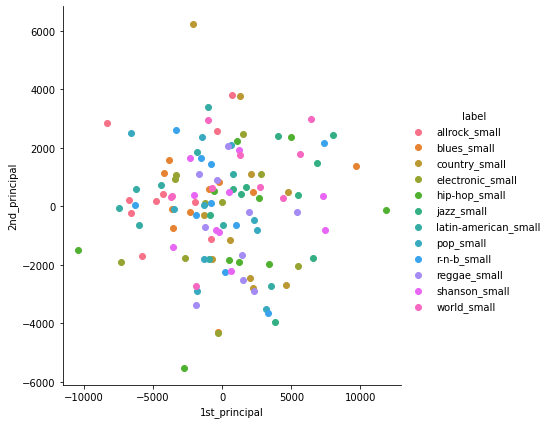

In [18]:
#Визуализация PCA small

if __name__ == '__main__':
    
    song = pd.read_csv('genres_pca_100_comp_of_song_small.csv') #dataframe
    data = song[[str(i) for i in range(100)]]
    data = data.fillna(0) 
    data = np.array(data)
    labels = song['class']
    
    pca = PCA(n_components=2)
    projected = pca.fit_transform(data)
    data_df = pd.DataFrame(projected, columns=["1st_principal", "2nd_principal"])
    data_df['label'] = labels
    sn.FacetGrid(data_df, hue="label", height=6).map(plt.scatter, "1st_principal", "2nd_principal").add_legend()
    plt.show()

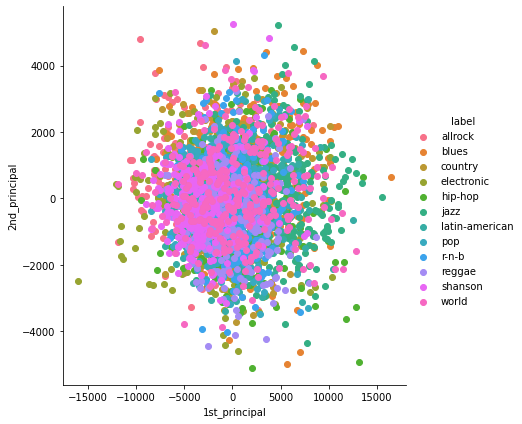

In [20]:
#Визуализация PCA full

if __name__ == '__main__':
    
    song = pd.read_csv('genres_pca_100_comp_of_song.csv') #dataframe
    data = song[[str(i) for i in range(100)]]
    data = data.fillna(0) 
    data = np.array(data)
    labels = song['class']
    
    pca = PCA(n_components=2)
    projected = pca.fit_transform(data)
    data_df = pd.DataFrame(projected, columns=["1st_principal", "2nd_principal"])
    data_df['label'] = labels
    sn.FacetGrid(data_df, hue="label", height=6).map(plt.scatter, "1st_principal", "2nd_principal").add_legend()
    plt.show()

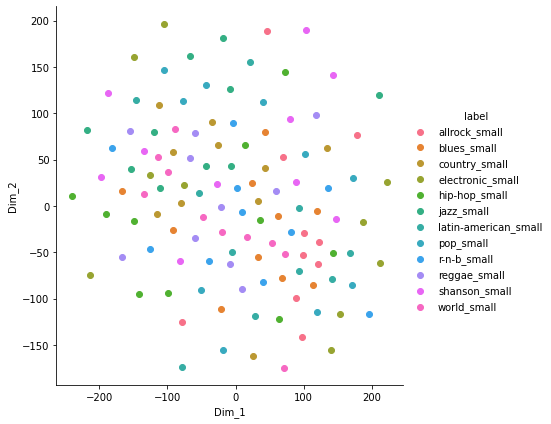

In [21]:
#Визуалзация T-SNE small
from sklearn.manifold import TSNE

if __name__ == '__main__':
    
    song = pd.read_csv('genres_pca_100_comp_of_song_small.csv') #dataframe
    data = np.array(song[[str(i) for i in range(100)]])
    labels = song['class']
    
    model = TSNE(n_components=2, random_state=0)
    # configuring the parameteres
    # the number of components = 2
    # default perplexity = 30
    # default learning rate = 200
    # default Maximum number of iterations for the optimization = 1000

    tsne_data = model.fit_transform(data)
    tsne_data = np.vstack((tsne_data.T, labels)).T

    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

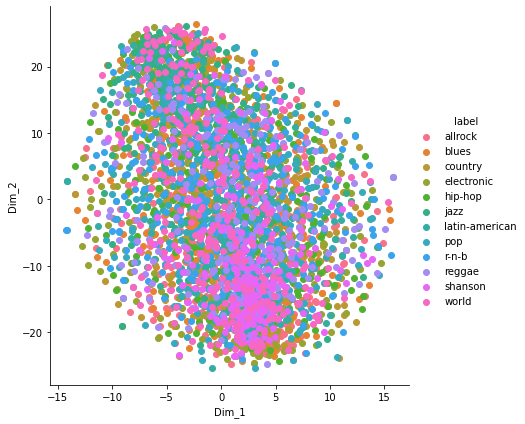

In [26]:
#Визуалзация T-SNE full
from sklearn.manifold import TSNE

if __name__ == '__main__':
    
    song = pd.read_csv('genres_pca_100_comp_of_song.csv') #dataframe
    data = np.array(song[[str(i) for i in range(100)]])
    labels = song['class']
    
    model = TSNE(n_components=2, random_state=0, perplexity = 50.0, learning_rate=1000.0, n_iter=500)
    # configuring the parameteres
    # the number of components = 2
    # default perplexity = 30
    # default learning rate = 200
    # default Maximum number of iterations for the optimization = 1000

    tsne_data = model.fit_transform(data)
    tsne_data = np.vstack((tsne_data.T, labels)).T

    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

In [3]:
#сохранение ravel файла со всеми 51680 компонентами
from sklearn.decomposition import PCA

def plot_pca_dispersion(song):
    pca = PCA().fit(song)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    return

def pca(song, n):
    pca = PCA(n_components=n)
    projected = pca.fit_transform(song)
    print(song.shape)
    print(projected.shape)
    return projected

if __name__ == '__main__':
    x_lim = 12920
    y_lim = 4
    
    song = pd.read_csv('genres_pca_mfcc.csv') #genres_pca_mfcc_small.csv
    lab = song['class']
    song = np.array(song[[str(i) for i in range(y_lim)]])
    print(song.shape)

    #разбиение на строки длиной 4*12920
    sound = np.zeros(shape = (1, x_lim * y_lim))
    label = []
    for i in range(song.shape[0] // x_lim):
        temp = song[i * x_lim : (i + 1) * x_lim, :]
        temp = temp.ravel()
        sound = np.vstack((sound, temp))
        label.append(lab[i * x_lim])
    sound = sound[1:, :]
    print(temp.shape)                          
       
    result = pd.DataFrame(sound)
    result['class'] = pd.Series(label)
    result.to_csv('genres_pca_4na12920_comp_of_song.csv', index = None)   #genres_pca_4*12920_comp_of_song_small.csv

(44418960, 4)
(51680,)


OSError: [Errno 22] Invalid argument: 'genres_pca_4*12920_comp_of_song.csv'

In [4]:
result.to_csv('genres_pca_4na12920_comp_of_song.csv', index = None)